# Initial Data Understanding



## Loading Data and Libraries

In [183]:
import unidecode
import os
import sys

sys.path.append('../src/')

import pandas as pd
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessamento dos dados de informações municipais


Antes de iniciar a análise exploratória dos dados, temos que limpar e transformar os dados que foram nos dados. Os arquivos são um csv com wide format onde as colunas são os meses e as linhas os municípios. Vou unpivotar a tabela, já que trabalhamos melhor em long format com dados temporais. Também, percebemos que diversos arquivos contém a mesma estrutura, o que faz sentido, já que apresentam basicamente a mesma informação. Portanto, irei concatená-los em um único arquivo e dataframe para facilitar o nosso processo.

In [2]:
# arquivos que serao concatenados
files_to_concat = [file  for file in os.listdir('../data/raw/') 
                   if file.startswith('equipes') or file.startswith('rf') or file.startswith('rh')]
files_to_concat

['rf_tomografos_computadorizados.csv',
 'rf_mamografos.csv',
 'rfressonancia_magnetica.csv',
 'equipes_de_saude_equipes_saude_da_familia.csv',
 'rh_medicos.csv',
 'equipes_de_saude_nucleos_de_apoio_a_saude_da_familia_nasf.csv',
 'rf_leitos_de_internacao.csv',
 'rh_enfermeiros.csv',
 'rf_raios_x.csv']

Criamos algumas funções auxiliares para nos ajudar na tarefa.

In [3]:
import preprocess

df_combined = preprocess.combine(files_to_concat)

In [4]:
df_combined.head(5)

,municipio_rf_tomografos_computadorizados,data_rf_tomografos_computadorizados,rf_tomografos_computadorizados,municipio_rf_mamografos,data_rf_mamografos,rf_mamografos,municipio_rfressonancia_magnetica,data_rfressonancia_magnetica,rfressonancia_magnetica,municipio_equipes_de_saude_equipes_saude_da_familia,...,equipes_de_saude_nucleos_de_apoio_a_saude_da_familia_nasf,municipio_rf_leitos_de_internacao,data_rf_leitos_de_internacao,rf_leitos_de_internacao,municipio_rh_enfermeiros,data_rh_enfermeiros,rh_enfermeiros,municipio_rf_raios_x,data_rf_raios_x,rf_raios_x
0,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,2014/jan,-,110001 Alta Floresta D'Oeste,...,1,110001 Alta Floresta D'Oeste,2014/jan,45,110001 Alta Floresta D'Oeste,2014/jan,14,110001 Alta Floresta D'Oeste,2014/jan,1
1,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,2014/jan,-,110037 Alto Alegre dos Parecis,...,1,110037 Alto Alegre dos Parecis,2014/jan,16,110037 Alto Alegre dos Parecis,2014/jan,6,110037 Alto Alegre dos Parecis,2014/jan,-
2,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,2014/jan,-,110040 Alto Paraíso,...,-,110040 Alto Paraíso,2014/jan,15,110040 Alto Paraíso,2014/jan,7,110040 Alto Paraíso,2014/jan,1
3,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,2014/jan,-,110034 Alvorada D'Oeste,...,-,110034 Alvorada D'Oeste,2014/jan,35,110034 Alvorada D'Oeste,2014/jan,10,110034 Alvorada D'Oeste,2014/jan,1
4,110002 Ariquemes,2014/jan,1,110002 Ariquemes,2014/jan,1,110002 Ariquemes,2014/jan,1,110002 Ariquemes,...,1,110002 Ariquemes,2014/jan,85,110002 Ariquemes,2014/jan,54,110002 Ariquemes,2014/jan,4


Ao analisar com mais detalhe o dado, vimos que para alguns arquivos, temos informações até agosto de 2019, sendo assim, temos que tomar cuidado para não dropar linhas de arquivos que contém essas informações. Vamos manter aquela coluna de data que contém o maior número de informações não nulas.

In [5]:
df_combined.isnull().sum(0)

municipio_rf_tomografos_computadorizados                               44776
data_rf_tomografos_computadorizados                                    44776
rf_tomografos_computadorizados                                         44776
municipio_rf_mamografos                                                44776
data_rf_mamografos                                                     44776
rf_mamografos                                                          44776
municipio_rfressonancia_magnetica                                      44776
data_rfressonancia_magnetica                                           44776
rfressonancia_magnetica                                                44776
municipio_equipes_de_saude_equipes_saude_da_familia                        0
data_equipes_de_saude_equipes_saude_da_familia                             0
equipes_de_saude_equipes_saude_da_familia                                  0
municipio_rh_medicos                                                   44776

In [6]:
columns_to_keep = [col for col in df_combined.columns if not col.startswith('municipio')
                  and not col.startswith('data')]

columns_to_keep += ['municipio_equipes_de_saude_equipes_saude_da_familia',
                    'data_equipes_de_saude_equipes_saude_da_familia']

In [7]:
df_final = df_combined[columns_to_keep].copy()
df_final = df_final.rename(columns={
    'municipio_equipes_de_saude_equipes_saude_da_familia': 'municipio',
    'data_equipes_de_saude_equipes_saude_da_familia': 'data'
})

df_final.shape

(380596, 11)

Pronto, temos um dado mais normalizado e limpo, porém temos mais alguns ajustes a fazer. Valores que contém hífen são aqueles que não obtivemos números, então irei substituílos por zero.

In [8]:
df_final = df_final.replace('-', 0)

In [9]:
# cols to conver
columns_to_convert = [col for col in df_final.columns 
                      if col not in ['municipio', 'data']]

In [10]:
df_final[columns_to_convert] = df_final[columns_to_convert].astype(np.float)

Por fim, irei normalizar os valores de municipio, bem como criar uma coluna extra com o código do mesmo, assim conseguimos cruzar depois com dados da APAC.

In [11]:
df_final['cod_municipio'] = df_final.municipio.apply(lambda x: x.split()[0]).astype(int)
df_final['nom_municipio'] = df_final.municipio.apply(lambda x: ' '.join(x.split()[1:]))

In [12]:
# Criando colunas do tipo datetime

In [13]:
english_abbr = {'jan': 'jan',
                'fev': 'feb',
                'mar': 'mar',
                'abr': 'apr',
                'mai': 'may',
                'jun': 'jun',
                'jul': 'jul',
                'ago': 'aug',
                'set': 'sep',
                'out': 'oct',
                'nov': 'nov',
                'dez': 'dec'}

convert_to_eng = lambda x: english_abbr[x.group()]
df_final['data'] = df_final.data.str.replace('([a-z]+)', convert_to_eng)

In [14]:
df_final['data'] = pd.to_datetime(df_final.data.values)

In [15]:
# salvando arquivo para nao precisar processar novamente
df_final.to_csv('../data/preprocessed/recursos_fis_hum_equi.csv', index=False)

## Análise Exploratória

Vemos que a estrutura do nosso dado é temporal, ela apresenta então três grupos diferentes de características:

 - Para aqueles arquivos/colunas que começam com rf, temos a quantidade de recursos físicos encontrados no munícipio por data, isto é, estes recursos físicos contam coisas como: 
     - Leitos de Internação
     - Ressonância Magnética
     - Mamógrafos
     - Tomografias Computadorizadas
     - Aparelhos de Raio-X
 - Já para aqueles iniciados com rf, temos a quantidade de recursos humanos dispoíveis, entre eles:
     - Enfermeiros
     - Médicos
 - E por fim, equipes de saúde da família:
     - Equipe de Saúda da Família
     - Equipe de Saúda da Família - NASF Modalidade 1
     
Vamos começar a entender estes dados através de uma análise dos dados disponíveis neste conjunto, depois de termos um conhecimento mais aprofundado deste, iremos partir para cruzamentos com os dados da apac.

### Visualizações Geoespaciais

Dada as características únicas deste dataset como sua organização de informação por munícipio, surge a necessidade de visualizarmos as informações em formato geoespacial, para isto iremos utilizar um shapefile obtido através do site do IBGE relacionando código do muncípio e suas coordenada no mapa brasileiro.

In [16]:
gdf_mun = gpd.read_file('../data/external/shapefile_municipios/municipios_2010.shp')
gdf_mun.head(4)

,id,nome,uf,populacao,pib,estado_id,codigo_ibg,geometry
0,3284,Cruz Machado,PR,18040,145687,18,4106803,POLYGON ((-50.98167953708689 -25.6657194057046...
1,3287,Curiúva,PR,13923,127042,18,4107009,POLYGON ((-50.36107073307947 -23.8822439964929...
2,94,Paulo Jacinto,AL,7426,27235,2,2706604,POLYGON ((-36.36575491835766 -9.36100866164145...
3,2629,Cuitegi,PB,6889,29196,15,2505204,POLYGON ((-35.47235871306991 -6.92276896015657...


O código municipio do nosso dataset se relaciona com o codigo ibge acima através dos primeiros n-1 caracteres.

In [107]:
gdf_mun['cod_municipio'] = gdf_mun.codigo_ibg.apply(lambda x: int(x[:-1]))
gdf_mun['populacao'] = gdf_mun.populacao.astype(float)
gdf_mun['estado_id'] = gdf_mun.estado_id.astype(int)

#### Número de Recursos Humanos (Médio) por Município

In [113]:
rh_cols = ['rh_enfermeiros', 'rh_medicos']

grp_mun = df_final.groupby(['nom_municipio', 'cod_municipio'])


mun_avg_rh = (grp_mun.agg({'rh_enfermeiros': 'mean',
                         'rh_medicos': 'mean'})
              .reset_index())

mun_avg_rh = gdf_mun.merge(mun_avg_rh, on='cod_municipio')

In [114]:
for col in rh_cols:
    mun_avg_rh[col+'_norm'] = (mun_avg_rh[col] / mun_avg_rh['populacao'])*100

Top Municipíos com mais recursos:

       nom_municipio  rh_enfermeiros    rh_medicos
5541       São Paulo    19756.533333  38285.183333
2397  Rio de Janeiro    12033.516667  20968.233333
97    Belo Horizonte     4950.383333  14443.050000
4500        Salvador     4793.700000   7480.966667
814         Brasília     4275.433333   8766.583333
2977    Porto Alegre     3511.850000   7852.850000
3478          Recife     3467.700000   5938.500000
4612       Fortaleza     2827.850000   5879.033333
3234        Curitiba     2758.800000   7484.933333
4197        Campinas     2252.850000   5788.483333
4163          Manaus     1962.950000   3143.700000
4947         Goiânia     1815.800000   5250.300000
5317        São Luís     1698.016667   1860.550000
721      João Pessoa     1523.250000   2361.350000
5462           Belém     1353.366667   3168.516667


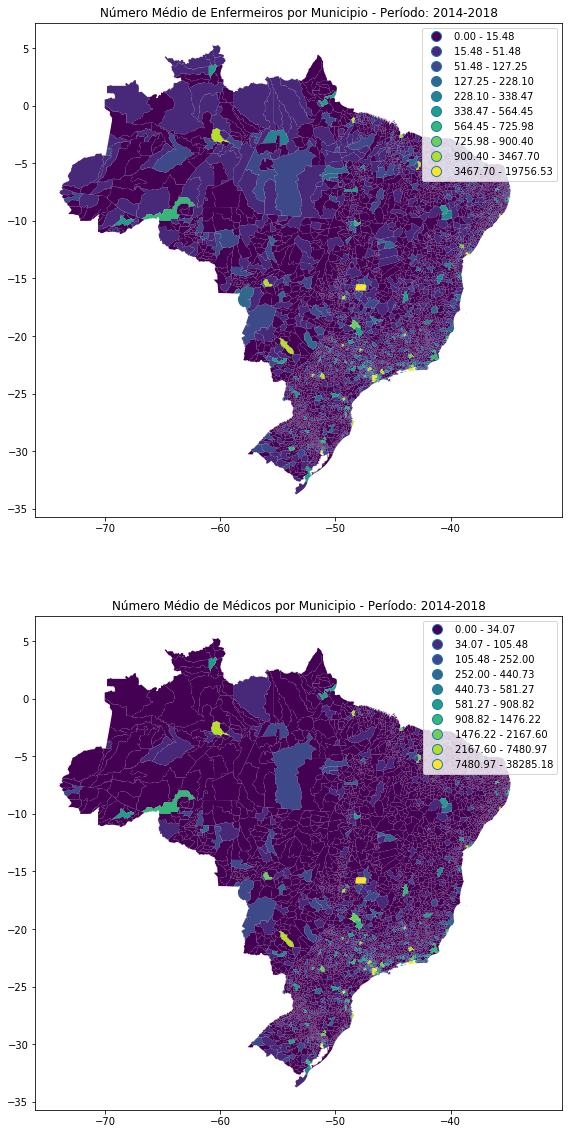

In [95]:
import plotting

fig, axes = plt.subplots(2, 1, figsize=(25, 20))

geoplot_args = {'scheme':'Fisher_Jenks_Sampled',
                'k':10,
                'legend':True}

axes = plotting.multiple_geoplot(mun_avg_rh,
                         columns=rh_cols,
                         axes=axes,
                         **geoplot_args)

axes[0].set_title('Número Médio de Enfermeiros por Municipio - Período: 2014-2018')
axes[1].set_title('Número Médio de Médicos por Municipio - Período: 2014-2018')

print("Top Municipíos com mais recursos:\n")
print(mun_avg_rh.nlargest(15, columns=rh_cols)[['nom_municipio'] + rh_cols])

Para a surpresa de ninguém, as capitais apresentam muito mais recursos do que o resto do país, o que acaba por distorcer nosso gráfico. Vamos fazer a mesma coisa para as colunas normalizadas pela população local.

Text(0.5, 1, 'Número Médio de Médicos normalizado pela População por Municipio - Período: 2014-2018')

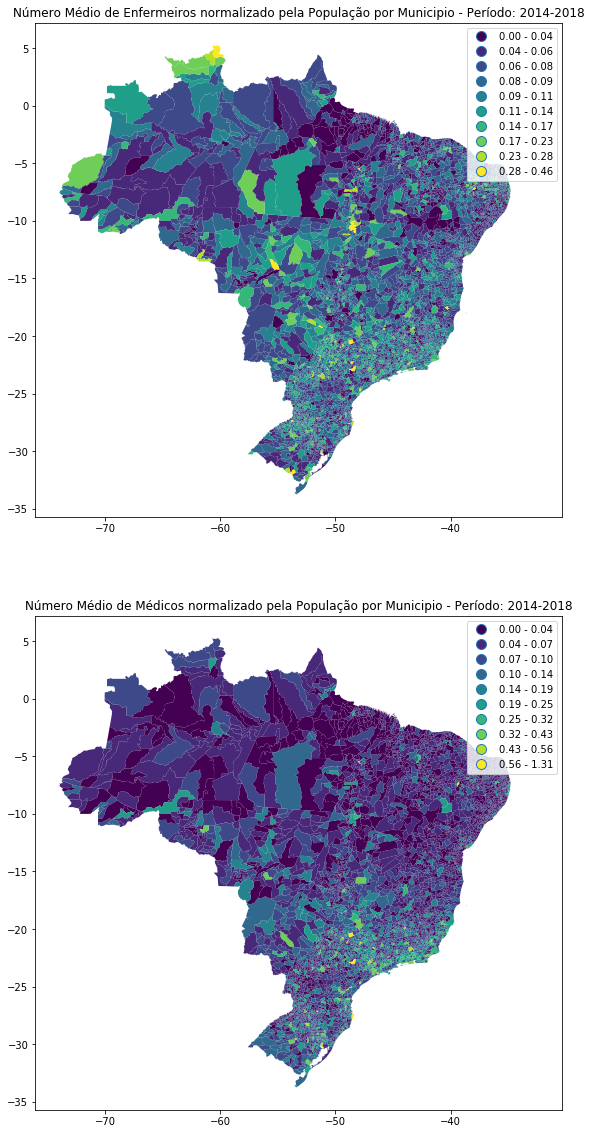

In [98]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))

axes = plotting.multiple_geoplot(mun_avg_rh,
                         columns=['rh_enfermeiros_norm',
                                  'rh_medicos_norm'],
                         axes=axes,
                         **geoplot_args)

axes[0].set_title('Número Médio de Enfermeiros normalizado pela População por Municipio - Período: 2014-2018')
axes[1].set_title('Número Médio de Médicos normalizado pela População por Municipio - Período: 2014-2018')

Nos mapas acima conseguimos ver uma distribuição melhor dos recursos alocados por município. Alguns padrões mostram que existe uma diferença entre proporção de número de médicos e número de enfermeiros. O que nós sabemos muito bem dos noticiários, médico é uma mão de obra cara e escassa e por muitas vezes há uma predominância dos mesmos em regiões com maior poder econômico como a região sudeste sul, enquanto na região norte o gráfico mostra que é limitado o número médio de médicos atuantes nos últimos anos. Vamos criar a mesma tratativa, porém agora por estado para ver se conseguimos detalhar estas ideias.

#### Número de Recursos Humanods (Médio) por Estado

Temos os recursos físicos médios (ao longo do tempo), por município, agora vamos somar para conseguirmos os dados por estado, isto é, dado o recurso médio dos últimos anos por município, vamos pegar o médio por estado.

In [130]:
gdf_est = (gpd.read_file('../data/external/Estados_do_Brasil/Brasil.shp')
          .rename(columns=str.lower))
gdf_est['cod_uf'] = gdf_est.cod_uf.astype(int)

In [137]:
est_avg_rh = (mun_avg_rh.groupby('uf').agg({'populacao': 'sum',
                                                  'rh_medicos': 'sum',
                                                  'rh_enfermeiros': 'sum'})
                         .reset_index())
est_avg_rh = gdf_est.merge(est_avg_rh, on='uf')

Text(0.5, 1, 'Número Médio de Médicos por Estado - Período: 2014-2018')

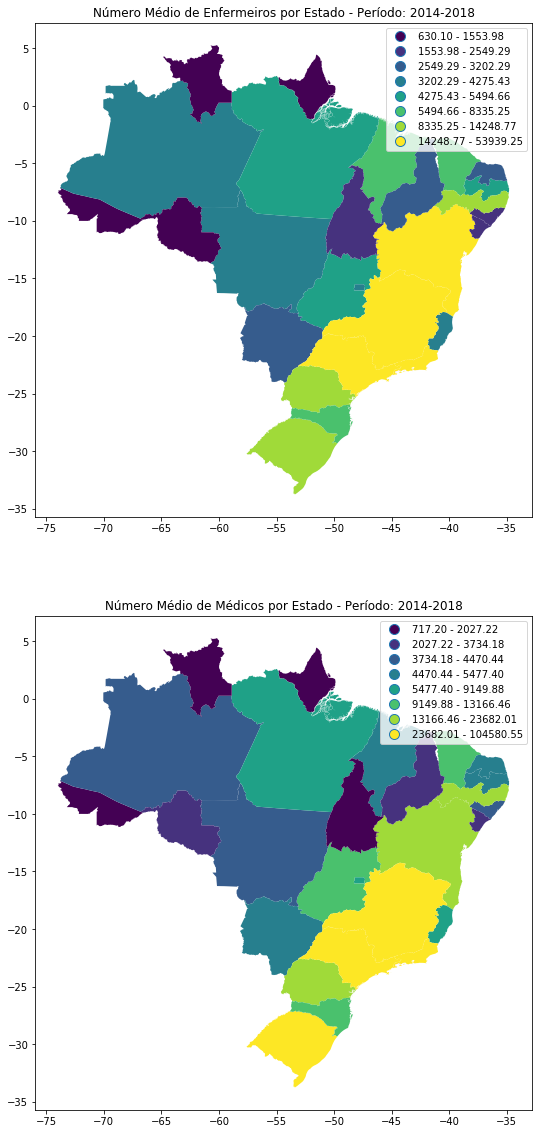

In [150]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))

geoplot_args = {'scheme': 'Quantiles',
                'k':8,
                'legend':True}

axes = plotting.multiple_geoplot(est_avg_rh,
                         columns=['rh_enfermeiros',
                                  'rh_medicos'],
                         axes=axes,
                         **geoplot_args)

axes[0].set_title('Número Médio de Enfermeiros por Estado - Período: 2014-2018')
axes[1].set_title('Número Médio de Médicos por Estado - Período: 2014-2018')

In [145]:
for col in rh_cols:
    est_avg_rh[col+'_norm'] = (est_avg_rh[col] / est_avg_rh['populacao'])*100

Text(0.5, 1, 'Número Médio de Médicos por Estado - Período: 2014-2018')

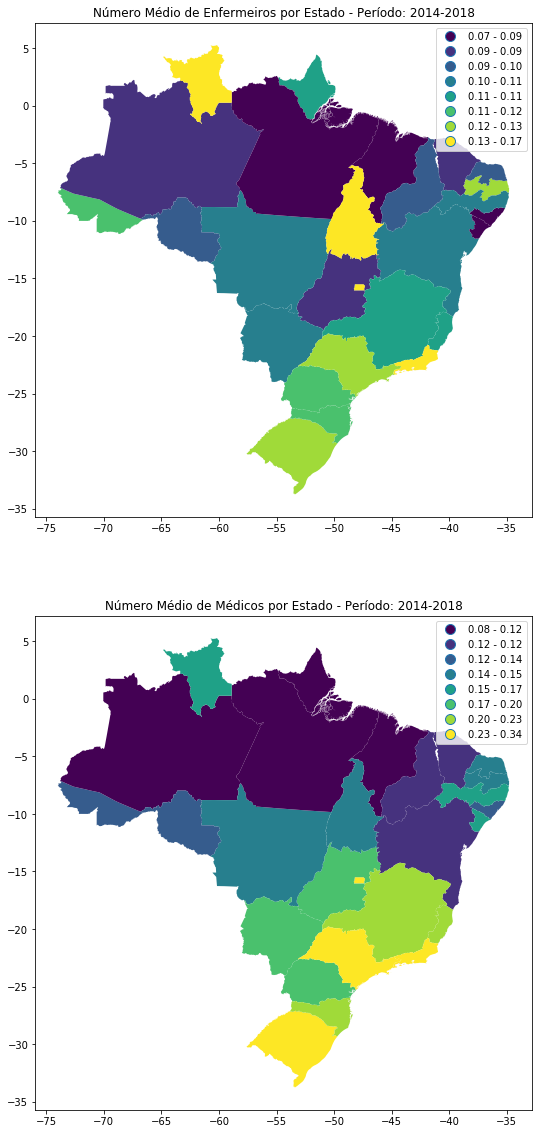

In [151]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))

geoplot_args = {'scheme': 'Quantiles',
                'k': 8,
                'legend':True}

axes = plotting.multiple_geoplot(est_avg_rh,
                         columns=['rh_enfermeiros_norm',
                                  'rh_medicos_norm'],
                         axes=axes,
                         **geoplot_args)

axes[0].set_title('Número Médio de Enfermeiros por Estado - Período: 2014-2018')
axes[1].set_title('Número Médio de Médicos por Estado - Período: 2014-2018')

Novamente, há uma predominância na região sudeste / sul na concentração de médicos, confirmando nossas intuições vistas acima. Até agora vimos este número de forma absoluta, mostrando o número médio por região. Porém, ignorar o fator temporal nos dados seria desperdiçar recursos.

#### Quadro de evolução do número de Recursos Humanos por Região - Período: 2014-2018

In [159]:
df_merged = gdf_mun.merge(df_final, on='cod_municipio', how='right')
df_merged = df_merged.merge(gdf_est, on='uf', how='left', suffixes=('_mun', '_est'))
df_merged['geometry'] = df_merged.geometry_est.values

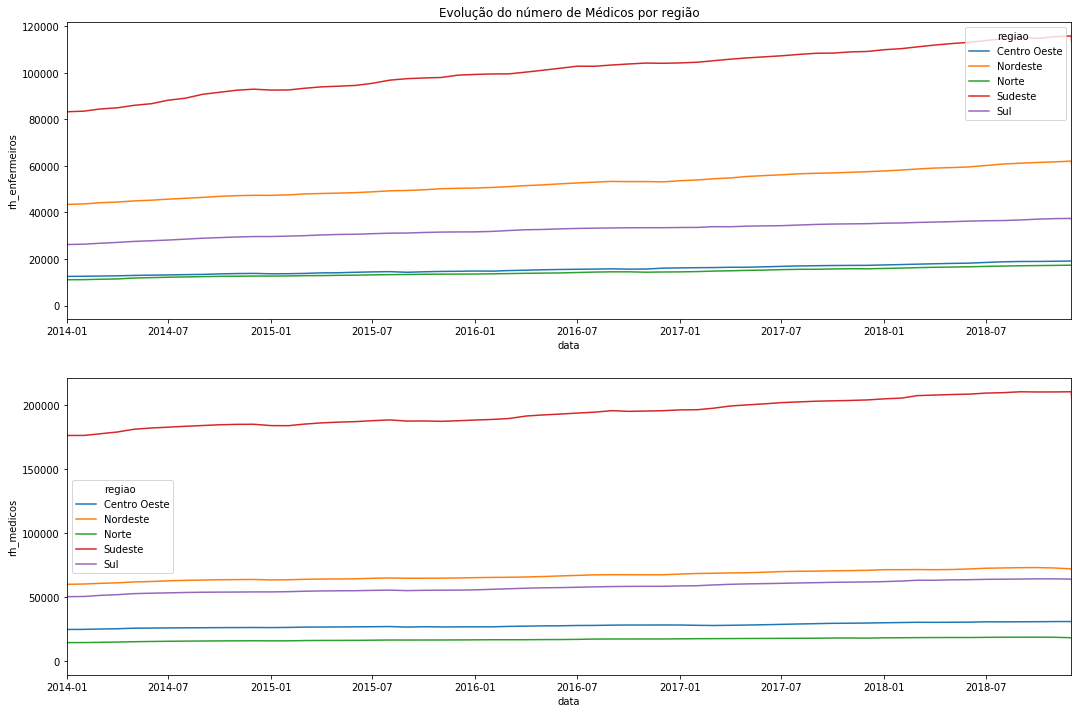

In [197]:
reg_total_rh = df_merged.groupby(['regiao', 'data'], as_index=False)[rh_cols].sum()
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

for i, col in enumerate(rh_cols):
    sns.lineplot(x="data", 
                 y=col, 
                 data=reg_total_rh,
                 hue="regiao",
                 color="b",
                 ax=ax[i]);

    ax[i].set_xlim('2014-01', '2018-12');
    
ax[0].set_title("Evolução do número de Enfermeiros por região")
ax[0].set_title("Evolução do número de Médicos por região");

#### Quadro de evolução do número de Recursos Humanos por Estado - Período: 2014-2018

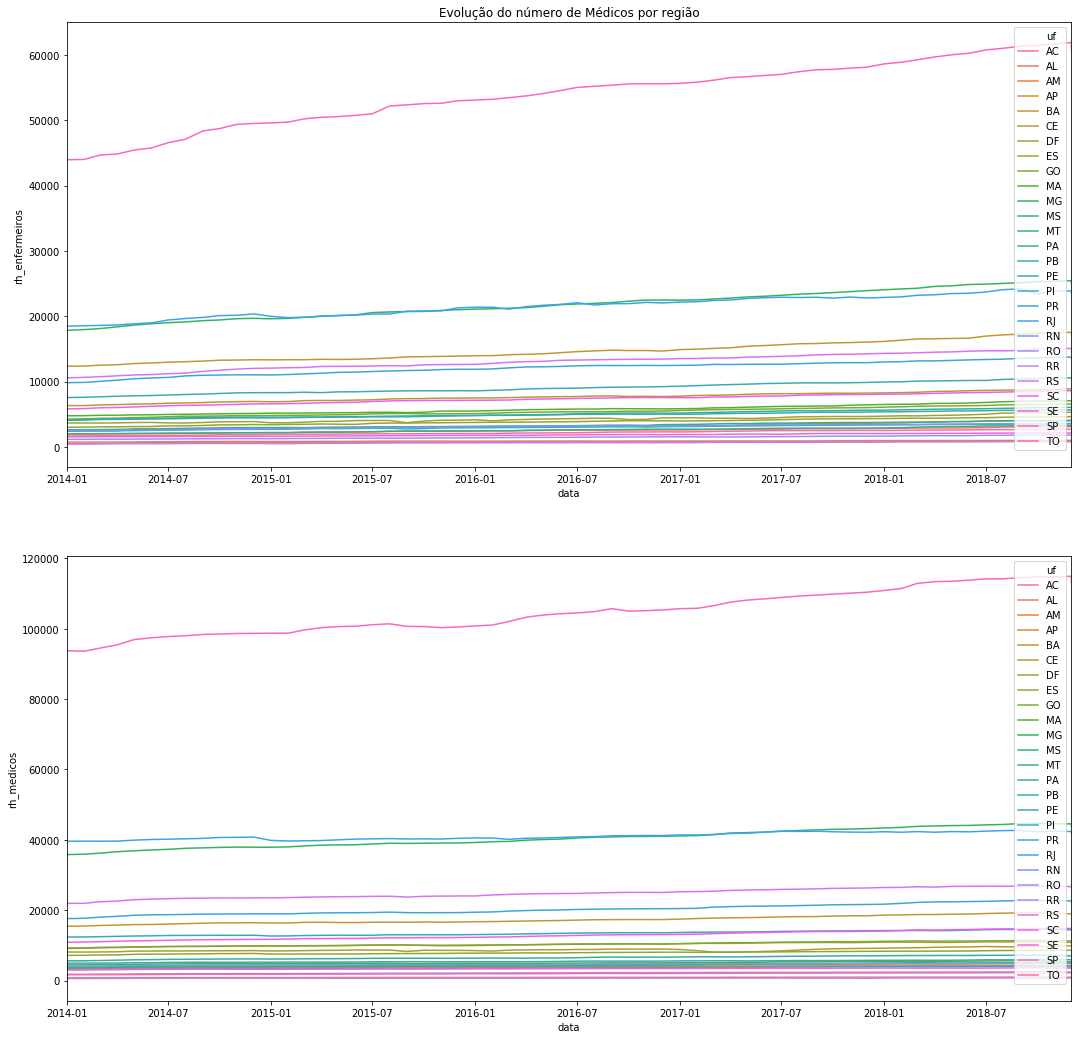

In [200]:
est_total_rh = df_merged.groupby(['uf', 'data'], as_index=False)[rh_cols].sum()

fig, ax = plt.subplots(2, 1, figsize=(18, 18))

for i, col in enumerate(rh_cols):
    sns.lineplot(x="data", 
                 y=col, 
                 data=est_total_rh,
                 hue="uf",
                 color="b",
                 ax=ax[i]);

    ax[i].set_xlim('2014-01', '2018-12');
    
ax[0].set_title("Evolução do número de Enfermeiros por estado")
ax[0].set_title("Evolução do número de Médicos por estado");

Nos gráficos acima vemos um padrão bem claro, existe um acréscimo nos últimos anos em relação ao número de recursos humanos (médicos, enfermeiros, auxiliares, porém em algumas regiões isto é mais acentuada, novamente confirmando a tendência que no Norte e Nordeste este aumento não é tão significativo.

Porém seguindo a linha de trabalhar também com valores relativos, vamos ver se a mesma distribuição se mantém quando os valores de crescimento são normalizados tendo como referência o primeiro ano.

In [311]:
reg_total_rh_pivoted = reg_total_rh.pivot(index='data', columns='regiao')
reg_total_rh_pivoted = reg_total_rh_pivoted[:'2018-12']



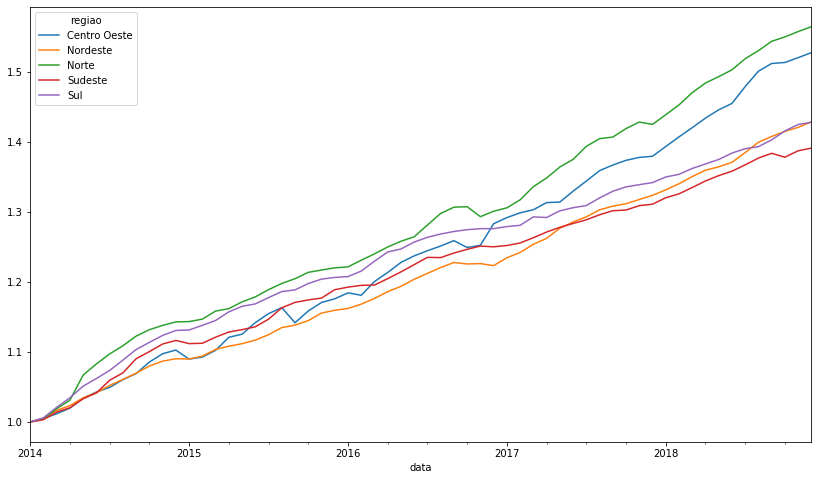

In [330]:
(reg_total_rh_pivoted['rh_enfermeiros'] / reg_total_rh_pivoted['rh_enfermeiros'].values[0]).plot(figsize=(14, 8))